In [17]:
import re
import nltk
import numpy as np
import pandas as pd
import networkx as nx
from gensim.utils import simple_preprocess
from wordcloud import WordCloud

from tqdm import tqdm
tqdm.pandas()
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('../dataset/movie.csv')
df = df.loc[:5000]
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.strip()
print(df['label'].value_counts())
df.head()

label
0    2582
1    2419
Name: count, dtype: int64


,text,label
0,i grew up (b. 1965) watching and loving the th...,0
1,"when i put this movie in my dvd player, and sa...",0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


# Regex: Detecting Occurences

In [71]:
x = df.loc[0,'text']
x

'i grew up (b. 1965) watching and loving the thunderbirds. all my mates at school watched. we played "thunderbirds" before school, during lunch and after school. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my children to see the movie hoping they would get a glimpse of what i loved as a child. how bitterly disappointing. the only high point was the snappy theme tune. not that it could compare with the original score of the thunderbirds. thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created. jonatha frakes should hand in his directors chair, his version was completely hopeless. a waste of film. utter rubbish. a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp. sapiens was a huge error of judgment.'

In [16]:
re.search('school',x)

<re.Match object; span=(74, 80), match='school'>

In [15]:
re.findall('school',x)

['school', 'school', 'school']

In [18]:
re.split('school',x)

['i grew up (b. 1965) watching and loving the thunderbirds. all my mates at ',
 ' watched. we played "thunderbirds" before ',
 ', during lunch and after ',
 '. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my children to see the movie hoping they would get a glimpse of what i loved as a child. how bitterly disappointing. the only high point was the snappy theme tune. not that it could compare with the original score of the thunderbirds. thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created. jonatha frakes should hand in his directors chair, his version was completely hopeless. a waste of film. utter rubbish. a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp. sapiens was a huge error of judgment.']

### Using Patterns

In [24]:
print(re.findall(r'[0-9]',x))
print(re.findall(r'[0-9]+',x))

['1', '9', '6', '5', '5']
['1965', '5']


In [25]:
re.findall('th[a-z]*',x)

['the',
 'thunderbirds',
 'thunderbirds',
 'the',
 'they',
 'the',
 'the',
 'theme',
 'that',
 'th',
 'the',
 'the',
 'thunderbirds',
 'thankfully',
 'the',
 'tha',
 'th']

In [48]:
x = "smua pria sm aj. cm km yg bda. 1 L0v3 Y0u"
re.findall('[sm]+[u]?[a-z]+',x)
re.findall('[0-9]',x)

['1', '0', '3', '0']

In [49]:
if re.findall('[0-9]',x):
    print("The string contains digits!")
else:
    print("string is clean!")

The string contains digits!


### Sample Usage

In [51]:
# Removing digits
df['text'].apply(lambda x: re.sub('[0-9]+','',x))

0       i grew up (b. ) watching and loving the thunde...
1       when i put this movie in my dvd player, and sa...
2       why do people who do not know what a particula...
3       even though i have great interest in biblical ...
4       im a die hard dads army fan and nothing will e...
                              ...                        
4996    one of frances farmer's earliest movies; at , ...
4997    i rented this thinking it would be pretty good...
4998    we went into this movie because my husband had...
4999    i think this movie was made backwards, first t...
5000    i was an usherette in an old theater in northe...
Name: text, Length: 5001, dtype: object

In [100]:
# Word Searching
df['text'].apply(lambda x: "good" if len(re.findall('.good .',x)) > 0 else "bad")

0        bad
1       good
2        bad
3        bad
4        bad
        ... 
4996     bad
4997    good
4998     bad
4999     bad
5000    good
Name: text, Length: 5001, dtype: object

In [89]:
# Searching for non-alphanumeric chars except spaces
df['text'].apply(lambda x: np.unique([i.strip() for i in re.findall('[^\w]+',x) if i != " "]))

0                                    [", (, ), ,, .]
1       [', (, ),, )., ,, -, ., . (, .<, />, /><, :]
2                           [!", ', ,, -, ., ?, ? "]
3                                             [,, .]
4        [", ', (, ), ).<, ,, -, ., . <, /, />, /><]
                            ...                     
4996                                 [', ,, -, ., ;]
4997                                       [', ,, .]
4998                       [!, ", ', '., ,, -, ., `]
4999                       [', ,, -, ., .<, />, /><]
5000              [!, !", ', (, )., ,, , ", -, ., ;]
Name: text, Length: 5001, dtype: object

In [90]:
df['text'].apply(lambda x: re.findall(' {2,}',x))

0       []
1       []
2       []
3       []
4       []
        ..
4996    []
4997    []
4998    []
4999    []
5000    []
Name: text, Length: 5001, dtype: object

In [117]:
# Replace extra whitespaces in text
x = "halo  salam kenal. hai"
re.sub(" {2,}"," ",x)

'halo salam kenal. hai'

In [122]:
re.findall(r'\bh\w+',x)

['halo', 'hai']

In [124]:
re.findall(r'\bhalo\b',x)

['halo']

# N-Gram

In [4]:
df['tokens_gensim'] = df['text'].progress_apply(simple_preprocess)

100%|██████████| 5001/5001 [00:01<00:00, 4731.31it/s]


In [5]:
def generate_bigrams(text):
    # Clean and split text into words
    words = re.findall(r'\w+', text.lower())  # extract words and lower case
    # Generate bi-grams
    bigrams = list(zip(words, words[1:]))
    return bigrams

def build_directed_graph(bigrams):
    graph = defaultdict(list)
    for word1, word2 in bigrams:
        graph[word1].append(word2)
    return graph

In [6]:
stop_words = set(stopwords.words('english'))
a = list(stop_words)
a.append('br')
a.append('movie')
a.append('watch')

token_list = []
for i in df.loc[df['label']==0,'tokens_gensim']:
    token_list.extend(i) 

token_list = [i for i in token_list if i not in a]

In [167]:
bigrams = generate_bigrams(' '.join(token_list))
bigrams

[('grew', 'watching'),
 ('watching', 'loving'),
 ('loving', 'thunderbirds'),
 ('thunderbirds', 'mates'),
 ('mates', 'school'),
 ('school', 'watched'),
 ('watched', 'played'),
 ('played', 'thunderbirds'),
 ('thunderbirds', 'school'),
 ('school', 'lunch'),
 ('lunch', 'school'),
 ('school', 'wanted'),
 ('wanted', 'virgil'),
 ('virgil', 'scott'),
 ('scott', 'one'),
 ('one', 'wanted'),
 ('wanted', 'alan'),
 ('alan', 'counting'),
 ('counting', 'became'),
 ('became', 'art'),
 ('art', 'form'),
 ('form', 'took'),
 ('took', 'children'),
 ('children', 'see'),
 ('see', 'hoping'),
 ('hoping', 'would'),
 ('would', 'get'),
 ('get', 'glimpse'),
 ('glimpse', 'loved'),
 ('loved', 'child'),
 ('child', 'bitterly'),
 ('bitterly', 'disappointing'),
 ('disappointing', 'high'),
 ('high', 'point'),
 ('point', 'snappy'),
 ('snappy', 'theme'),
 ('theme', 'tune'),
 ('tune', 'could'),
 ('could', 'compare'),
 ('compare', 'original'),
 ('original', 'score'),
 ('score', 'thunderbirds'),
 ('thunderbirds', 'thankfully'

In [168]:
directed_graph = build_directed_graph(bigrams)
for node, edges in directed_graph.items():
    print(f"{node} -> {', '.join(edges)}")

grew -> watching, old, got, strikes, older, bit, watching, end, loves, bigger, loving, threw, starbucks, child, single, following, wear
watching -> loving, film, assembly, material, new, enter, rest, either, though, bring, excited, instead, car, film, many, story, even, ok, actors, first, bsg, regular, halfway, awake, bad, nephew, film, something, looking, dull, preface, late, attack, stiller, every, tashan, first, sexual, serious, monstrosity, dude, wanted, piece, suppose, via, stars, closet, mayne, involved, whole, horror, started, wife, afraid, new, story, bad, things, son, lost, nudity, sctv, makes, obnoxious, expecting, movies, actually, exact, unkempt, grass, us, four, dull, thinking, pops, anyway, similar, next, good, slaps, see, hoping, cbs, mr, rape, stupid, tricked, flick, course, unless, trial, wish, concur, amazingly, something, total, sort, said, first, people, entirely, anytime, short, especially, believe, play, paint, mother, hoping, getting, let, many, film, five, good,

In [7]:
text = ' '.join(token_list)
nltk_tokens = nltk.word_tokenize(text)  	

nltk_bigrams = list(nltk.bigrams(nltk_tokens))
nltk_trigrams = list(nltk.ngrams(nltk_tokens,n=3))

Text(0.5, 0, '# of Occurances')

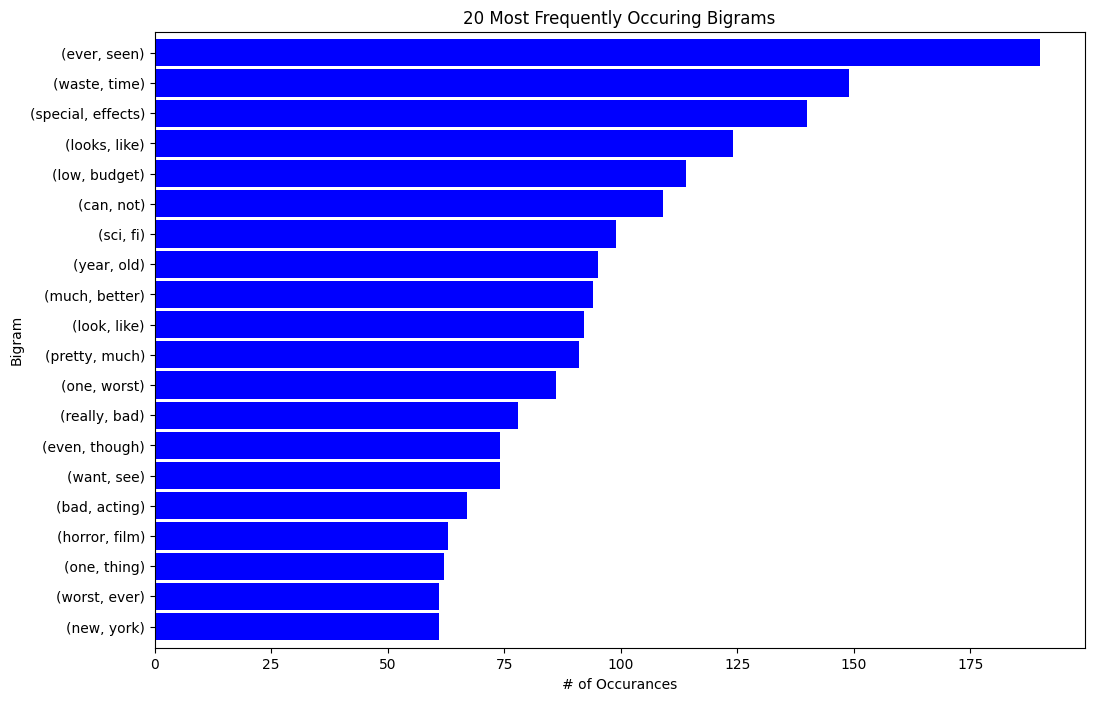

In [170]:
true_bigrams_series = (pd.Series(nltk.ngrams(nltk_tokens, 2)).value_counts())[:20]
true_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [184]:
ngram_ser = pd.Series(nltk.ngrams(nltk_tokens, 2)).value_counts().reset_index()
ngram_ser['index'] = ngram_ser['index'].apply(lambda x: " ".join(x))
ngram_ser.index = ngram_ser['index']
ngram_ser = ngram_ser.drop(columns=['index']).to_dict()
ngram_ser

{'count': {'ever seen': 190,
  'waste time': 149,
  'special effects': 140,
  'looks like': 124,
  'low budget': 114,
  'can not': 109,
  'sci fi': 99,
  'year old': 95,
  'much better': 94,
  'look like': 92,
  'pretty much': 91,
  'one worst': 86,
  'really bad': 78,
  'even though': 74,
  'want see': 74,
  'bad acting': 67,
  'horror film': 63,
  'one thing': 62,
  'worst ever': 61,
  'new york': 61,
  'main character': 60,
  'whole thing': 59,
  'pretty good': 56,
  'bad film': 56,
  'movies ever': 54,
  'high school': 54,
  'seems like': 54,
  'make sense': 52,
  'first time': 51,
  'film making': 51,
  'character development': 50,
  'real life': 50,
  'movies like': 49,
  'bad guys': 49,
  'ever made': 48,
  'years ago': 48,
  'camera work': 48,
  'looked like': 48,
  'worth watching': 47,
  'good thing': 47,
  'would like': 46,
  'see film': 45,
  'gon na': 43,
  'film made': 43,
  'worst movies': 43,
  'one point': 42,
  'bad guy': 41,
  'writer director': 41,
  'bad bad': 40,


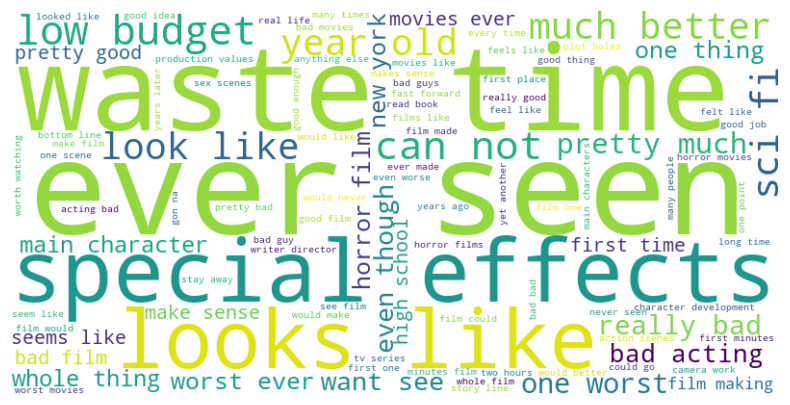

In [188]:
wordcloud = WordCloud(width=800, height=400, background_color='white',max_words=100).generate_from_frequencies(ngram_ser['count'])
    
# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.title(title, fontsize=18)
plt.axis('off')
plt.show()

# Network Analysis

In [232]:
def visualize_graph(graph):
    # Initialize directed graph
    G = nx.DiGraph()
    
    # Add edges to the graph
    for node, edges in tqdm(graph.items()):
        for edge in edges:
            G.add_edge(node, edge)
    
    # Draw the graph
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)  # Positioning the nodes using spring layout
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=8, font_weight='bold', 
            arrowstyle='->', arrowsize=20)
    plt.title("Directed Graph from Text Bi-grams")
    plt.show()

In [202]:
nltk_bigrams

[('grew', 'watching'),
 ('watching', 'loving'),
 ('loving', 'thunderbirds'),
 ('thunderbirds', 'mates'),
 ('mates', 'school'),
 ('school', 'watched'),
 ('watched', 'played'),
 ('played', 'thunderbirds'),
 ('thunderbirds', 'school'),
 ('school', 'lunch'),
 ('lunch', 'school'),
 ('school', 'wanted'),
 ('wanted', 'virgil'),
 ('virgil', 'scott'),
 ('scott', 'one'),
 ('one', 'wanted'),
 ('wanted', 'alan'),
 ('alan', 'counting'),
 ('counting', 'became'),
 ('became', 'art'),
 ('art', 'form'),
 ('form', 'took'),
 ('took', 'children'),
 ('children', 'see'),
 ('see', 'hoping'),
 ('hoping', 'would'),
 ('would', 'get'),
 ('get', 'glimpse'),
 ('glimpse', 'loved'),
 ('loved', 'child'),
 ('child', 'bitterly'),
 ('bitterly', 'disappointing'),
 ('disappointing', 'high'),
 ('high', 'point'),
 ('point', 'snappy'),
 ('snappy', 'theme'),
 ('theme', 'tune'),
 ('tune', 'could'),
 ('could', 'compare'),
 ('compare', 'original'),
 ('original', 'score'),
 ('score', 'thunderbirds'),
 ('thunderbirds', 'thankfully'

In [216]:
top_bigrams = pd.Series(nltk.ngrams(nltk_tokens, 2)).value_counts().reset_index().loc[:200]['index'].to_list()
directed_graph = build_directed_graph(top_bigrams)

In [223]:
x = pd.Series(nltk.ngrams(nltk_tokens, 2)).value_counts().reset_index()
x = x[x['count']>50]
top_bigrams = x['index'].to_list()
directed_graph = build_directed_graph(top_bigrams)

In [225]:
x

,index,count
0,"(ever, seen)",190
1,"(waste, time)",149
2,"(special, effects)",140
3,"(looks, like)",124
4,"(low, budget)",114
5,"(can, not)",109
6,"(sci, fi)",99
7,"(year, old)",95
8,"(much, better)",94
9,"(look, like)",92


100%|██████████| 27/27 [00:00<00:00, 26867.43it/s]


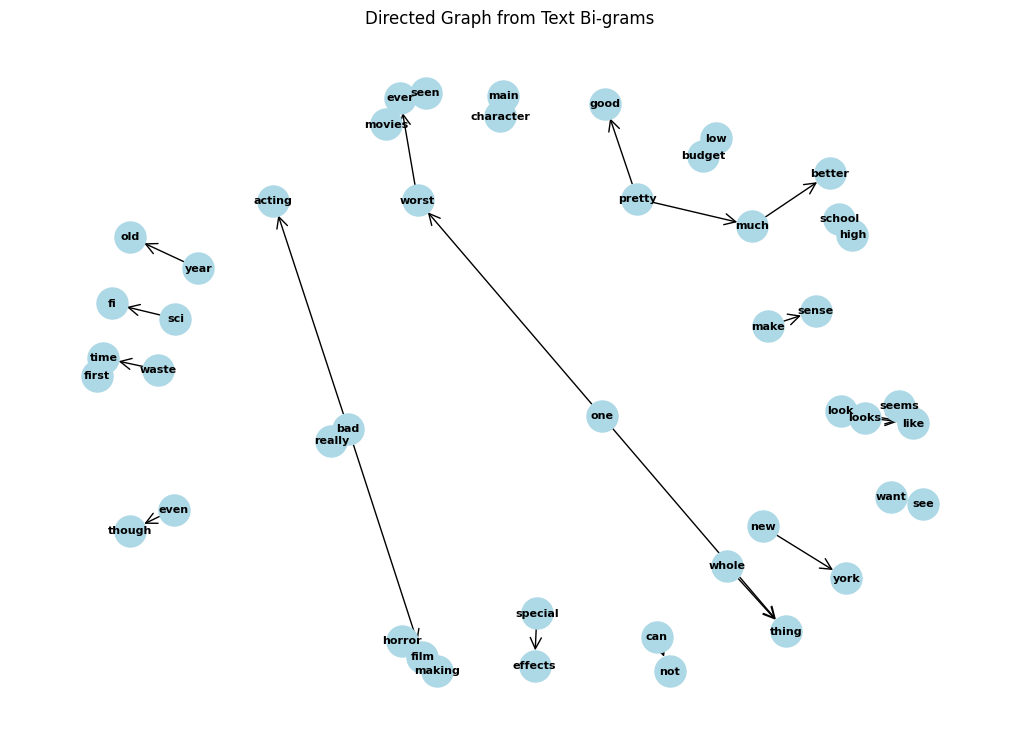

In [233]:
visualize_graph(directed_graph)

# NER

In [18]:
stop_words = set(stopwords.words('english'))
a = list(stop_words)
a.append('br')
a.append('movie')
a.append('watch')

token_list = []
temp_df = df.loc[:1000]
for i in temp_df.loc[temp_df['label']==0,'tokens_gensim']:
    token_list.extend(i) 

token_list = [i for i in token_list if i not in a]
text = ' '.join(token_list)

doc = nlp(text)

In [20]:
print([(x.text, x.label_) for x in doc.ents])

[('alan counting', 'PERSON'), ('early saturday', 'TIME'), ('one', 'CARDINAL'), ('gerry anderson', 'PERSON'), ('coke', 'PRODUCT'), ('first', 'ORDINAL'), ('atlantis', 'PRODUCT'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ('atlantis', 'PRODUCT'), ('first', 'ORDINAL'), ('one', 'CARDINAL'), ('three', 'CARDINAL'), ('first', 'ORDINAL'), ('three', 'CARDINAL'), ('moon landing', 'GPE'), ('diane lane', 'PERSON'), ('scott mcnealy', 'PERSON'), ('one', 'CARDINAL'), ('mcnealy', 'GPE'), ('microsoft', 'ORG'), ('microsoft', 'ORG'), ('scott mcnealy', 'PERSON'), ('japanese', 'NORP'), ('asian', 'NORP'), ('japanese korean', 'NORP'), ('john woo', 'PERSON'), ('hong kong', 'GPE'), ('tampopo chung', 'PERSON'), ('two', 'CARDINAL'), ('steven okazaki', 'PERSON'), ('one', 'CARDINAL'), ('two', 'CARDINAL'), ('brenda aoki', 'PERSON'), ('cbs', 'ORG'), ('half', 'CARDINAL'), ('chuck host', 'PERSON'), ('one', 'CARDINAL'), ('chuck', 'PERSON'), ('half want minutes', 'TIME'), ('davis bryan daly', 'PER